# Text classification

In [1]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/computational_ml_2/computing/neuralNets/

Mounted at /content/drive
/content/drive/MyDrive/computational_ml_2/computing/neuralNets


In [114]:
# Import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, Dense, Dropout, Embedding,
    Flatten, Input, Convolution1D, MaxPooling1D,
    concatenate, LSTM 
)
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import os
import pickle
from w2v import train_word2vec

np.random.seed(2)

# Load and preprocess data

In [115]:
embedding_dim = 50
max_sequence_length = 56
max_sequence_length_char = 148

In [116]:
# Load data
dt = pd.read_csv(
    os.path.join("data/data.txt"), sep="\t", header=None,
    names=["text", "labels"]
)

- Not necessary to remove stop words, but perhaps still useful to remove punctuation

In [117]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace('.',' ')
    text = text.replace(',',' ')
    text = text.replace('-',' ')
    text = text.replace('%','')
    text = text.replace(':',' ')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('\n',' ')
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('"',' ')
    text = text.replace('  ',' ')
    
    return text

In [119]:
texts = list(map(lambda x: preprocess_text(x), dt.text)) # preprocess
labels = list(dt.labels)

Now we need turn our text samples and labels into tensors that can be fed into a neural network.

In [120]:
# Word-wise:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens (words).' % len(word_index))

# Character-wise:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(texts)
sequences_char = tokenizer.texts_to_sequences(texts)

char_index = tokenizer.word_index
print('Found %s unique tokens (characters).' % len(char_index))

Found 2071 unique tokens (words).
Found 48 unique tokens (characters).


With the text now tokenized we can use `pad_sequences` to turn the sentences/texts into numerical sequences:

In [121]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
data_char = pad_sequences(sequences_char, maxlen=max_sequence_length_char)

We'll also rearrange the labels slightly:

In [122]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(labels))

Now both the text data and labels are in an adequate format to be passed to a neural network:

In [123]:
print('Shape of data tensor (words):', data.shape)
print('Shape of data tensor (characters):', data_char.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor (words): (1000, 56)
Shape of data tensor (characters): (1000, 148)
Shape of label tensor: (1000, 2)


## Embeddings

### Pre-trained embeddings - GloVe

Our sample is very small so instead of learning the embeddings from our sample it may be useful to use pre-trained embeddings. For starters we will rely on the smallest global vector embedding available from [GloVe](https://nlp.stanford.edu/projects/glove/), which is still considerable larger than any reasonable embedding we could learn form our sample.

Below we read the 50-$d$ embedding and store dictionary `embeddings_index` containing all words (keys) and their corresponding word vector (values).

In [11]:
GLOVE_DIR = "data/glove/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Now we can use the dictionary of words in our sample created earlier (`word_index`) and match them with their global word vectors if available in `embeddings_index`:

In [12]:
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
no_wv_available = []
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
  else:
    no_wv_available.append(word)

We can see that the the shape of the embedding tensor is in line with the sample as expected. For about 5% of the words in our sample we do not have a corresponding word vector.

In [13]:
print('Shape of embedding tensor:', embedding_matrix.shape)
print('No word vectors available for %i out of %i words.' % (len(no_wv_available), len(word_index)))

Shape of embedding tensor: (2072, 50)
No word vectors available for 101 out of 2071 words.


### Visualizing the word vectors

To get a better understanding of our embedded text, we can register the word vectors in a 2-dimensional subspace and  visualise them.

In [14]:
from matplotlib import pylab
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)
# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(embedding_matrix)

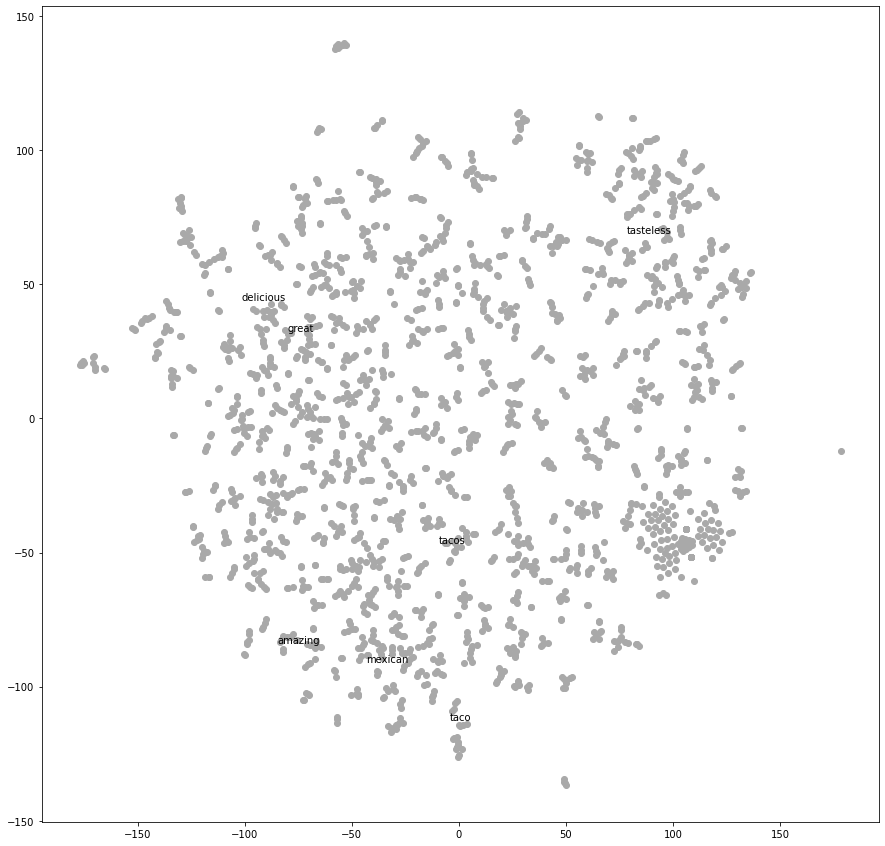

In [17]:
suggested_words = ['delicious', 'amazing', 'great',
                   'tasteless', 'digust',
                   'tacos', 'taco', 'mexican']
all_words = list(word_index.keys())
selected_words = [i for i in suggested_words if i in all_words]

pylab.figure(figsize=(15,15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(all_words):
  x, y = two_d_embeddings[i,:]
  pylab.scatter(x, y, c='darkgray')   
  if label in selected_words:
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                    ha='right', va='bottom',fontsize=10)
        
pylab.show()

# A first run

## Word-wise

In [292]:
# Model hyper parameters:
filter_sizes = (3, 4)
num_filters = 150
dropout_prob = (0.25, 0.5)
hidden_dims = 150
# Training parameters:
batch_size = 32
num_epochs = 10
val_split = 0.1
# Word2Vec parameters, see train_word2vec
min_word_count = 1  # Minimum word count                        
context = 10        # Context window size  

#### CNN

In [281]:
# Shuffle data
x = data
vocabulary_inv = ['<PAD/>'] + list(word_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)
texts_shuffled = [texts[i] for i in list(shuffle_indices)]
labels_shuffled = [dt.labels[i] for i in list(shuffle_indices)]

In [282]:
# Embedding:
model_variation = 'glove'
embedding_weights = {
    'glove': [embedding_matrix],
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layer = Embedding(
    len(word_index)+1,
    embedding_dim,
    weights=embedding_weights[model_variation],
    input_length=max_sequence_length
)

Loading existing Word2Vec model '50features_1minwords_10context'


In [127]:
graph_in = Input(shape=(max_sequence_length,embedding_dim))

convs = [] # list of flattened convolutions to be passed into network
for fsz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in)
    pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
    flatten = Flatten()(pool) # take output of convolution and flatten it
    convs.append(flatten)
    
if len(filter_sizes)>1:
    out = concatenate(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out)

# main sequential model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length,embedding_dim)))
model.add(graph)
model.add(Dense(hidden_dims))
model.add(Dropout(dropout_prob[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid')) # link function

In [128]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 2s - loss: 0.7475 - accuracy: 0.5789 - val_loss: 0.6260 - val_accuracy: 0.7100
Epoch 2/10
29/29 - 1s - loss: 0.6239 - accuracy: 0.6644 - val_loss: 0.5626 - val_accuracy: 0.7200
Epoch 3/10
29/29 - 1s - loss: 0.5553 - accuracy: 0.7222 - val_loss: 0.5902 - val_accuracy: 0.6600
Epoch 4/10
29/29 - 1s - loss: 0.4758 - accuracy: 0.7778 - val_loss: 0.4925 - val_accuracy: 0.7600
Epoch 5/10
29/29 - 1s - loss: 0.4215 - accuracy: 0.7989 - val_loss: 0.5697 - val_accuracy: 0.7100
Epoch 6/10
29/29 - 1s - loss: 0.3316 - accuracy: 0.8644 - val_loss: 0.7558 - val_accuracy: 0.6800
Epoch 7/10
29/29 - 1s - loss: 0.2926 - accuracy: 0.8900 - val_loss: 0.5935 - val_accuracy: 0.7100
Epoch 8/10
29/29 - 1s - loss: 0.2502 - accuracy: 0.8967 - val_loss: 0.4062 - val_accuracy: 0.8200
Epoch 9/10
29/29 - 1s - loss: 0.2105 - accuracy: 0.9211 - val_loss: 0.4383 - val_accuracy: 0.7800
Epoch 10/10
29/29 - 1s - loss: 0.1842 - accuracy: 0.9222 - val_loss: 0.6921 - val_accuracy: 0.7200


In [143]:
slice = 10
predicted = model.predict(x_shuffled[:slice])
pd.DataFrame({"sentence": texts_shuffled[:slice],"true": labels_shuffled[:slice], "pred": predicted.flatten()})

### RNN

In [151]:
# create the model 
embedding_vector_length = 32 
model = Sequential() 
model.add(embedding_layer) 
model.add(LSTM(100)) 
model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

In [152]:
# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 5s - loss: 0.6233 - accuracy: 0.6667 - val_loss: 0.5221 - val_accuracy: 0.7600
Epoch 2/10
29/29 - 2s - loss: 0.4829 - accuracy: 0.7844 - val_loss: 0.4201 - val_accuracy: 0.8300
Epoch 3/10
29/29 - 2s - loss: 0.3590 - accuracy: 0.8611 - val_loss: 0.4139 - val_accuracy: 0.8400
Epoch 4/10
29/29 - 2s - loss: 0.2548 - accuracy: 0.9111 - val_loss: 0.4636 - val_accuracy: 0.8400
Epoch 5/10
29/29 - 2s - loss: 0.2114 - accuracy: 0.9222 - val_loss: 0.4201 - val_accuracy: 0.8200
Epoch 6/10
29/29 - 2s - loss: 0.2042 - accuracy: 0.9256 - val_loss: 0.4543 - val_accuracy: 0.8100
Epoch 7/10
29/29 - 2s - loss: 0.1255 - accuracy: 0.9622 - val_loss: 0.4790 - val_accuracy: 0.8500
Epoch 8/10
29/29 - 2s - loss: 0.1028 - accuracy: 0.9678 - val_loss: 0.4518 - val_accuracy: 0.8400
Epoch 9/10
29/29 - 2s - loss: 0.0775 - accuracy: 0.9767 - val_loss: 0.5133 - val_accuracy: 0.7900
Epoch 10/10
29/29 - 2s - loss: 0.0623 - accuracy: 0.9867 - val_loss: 0.5177 - val_accuracy: 0.8000


In [153]:
slice = 10
predicted = model.predict(x_shuffled[:slice])
pd.DataFrame({"sentence": texts_shuffled[:slice],"true": labels_shuffled[:slice], "pred": predicted.flatten()})

,sentence,true,pred
0,we've have gotten a much better service from t...,0,0.001770
1,the jalapeno bacon is soooo good,1,0.987998
2,we'd definitely go back here again,1,0.986931
3,i'm not impressed with the concept or the food,0,0.012675
4,this place is awesome if you want something li...,1,0.999866
5,spend your money and time some place else,0,0.005946
6,i can say that the desserts were yummy,1,0.991458
7,the crêpe was delicate and thin and moist,1,0.992848
8,the decor is nice and the piano music soundtra...,1,0.999932
9,won't ever go here again,0,0.087181


## Character-wise

### CNN

In [ ]:
# Shuffle data
x = data_char
vocabulary_inv = ['<PAD/>'] + list(char_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)

In [ ]:
# Embedding:
model_variation = 'rand'
embedding_weights = {
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layer = Embedding(
    len(char_index)+1,
    embedding_dim,
    weights=embedding_weights[model_variation],
    input_length=max_sequence_length_char
)

Loading existing Word2Vec model '50features_1minwords_10context'


In [ ]:
graph_in = Input(shape=(max_sequence_length_char,embedding_dim))

convs = [] # list of flattened convolutions to be passed into network
for fsz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in)
    pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
    flatten = Flatten()(pool) # take output of convolution and flatten it
    convs.append(flatten)
    
if len(filter_sizes)>1:
    out = concatenate(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out)

# main sequential model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length_char,embedding_dim)))
model.add(graph)
model.add(Dense(hidden_dims))
model.add(Dropout(dropout_prob[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid')) # link function

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 3s - loss: 0.7364 - accuracy: 0.5011 - val_loss: 0.6854 - val_accuracy: 0.5800
Epoch 2/10
29/29 - 2s - loss: 0.6870 - accuracy: 0.5422 - val_loss: 0.6796 - val_accuracy: 0.6100
Epoch 3/10
29/29 - 3s - loss: 0.6613 - accuracy: 0.6289 - val_loss: 0.6852 - val_accuracy: 0.5500
Epoch 4/10
29/29 - 2s - loss: 0.5979 - accuracy: 0.6978 - val_loss: 0.6954 - val_accuracy: 0.5800
Epoch 5/10
29/29 - 2s - loss: 0.5405 - accuracy: 0.7311 - val_loss: 0.7118 - val_accuracy: 0.5400
Epoch 6/10
29/29 - 2s - loss: 0.4700 - accuracy: 0.7911 - val_loss: 0.6290 - val_accuracy: 0.6800
Epoch 7/10
29/29 - 3s - loss: 0.4118 - accuracy: 0.8222 - val_loss: 0.6984 - val_accuracy: 0.6400
Epoch 8/10
29/29 - 2s - loss: 0.3585 - accuracy: 0.8467 - val_loss: 0.6803 - val_accuracy: 0.6400
Epoch 9/10
29/29 - 2s - loss: 0.2848 - accuracy: 0.9000 - val_loss: 0.8296 - val_accuracy: 0.6100
Epoch 10/10
29/29 - 2s - loss: 0.2555 - accuracy: 0.8989 - val_loss: 0.7917 - val_accuracy: 0.6500


### RNN

In [256]:
# create the model 
embedding_vector_length = 32 
model = Sequential() 
model.add(embedding_layer) 
model.add(LSTM(100)) 
model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

In [257]:
# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 4s - loss: 0.5115 - accuracy: 0.8011 - val_loss: 0.4536 - val_accuracy: 0.8100
Epoch 2/10
29/29 - 2s - loss: 0.2274 - accuracy: 0.9389 - val_loss: 0.4886 - val_accuracy: 0.8000
Epoch 3/10
29/29 - 2s - loss: 0.1767 - accuracy: 0.9478 - val_loss: 0.4387 - val_accuracy: 0.8400
Epoch 4/10
29/29 - 2s - loss: 0.1179 - accuracy: 0.9633 - val_loss: 0.4093 - val_accuracy: 0.8500
Epoch 5/10
29/29 - 2s - loss: 0.0856 - accuracy: 0.9811 - val_loss: 0.5773 - val_accuracy: 0.8000
Epoch 6/10
29/29 - 2s - loss: 0.0610 - accuracy: 0.9878 - val_loss: 0.5115 - val_accuracy: 0.8200
Epoch 7/10
29/29 - 2s - loss: 0.0387 - accuracy: 0.9911 - val_loss: 0.5739 - val_accuracy: 0.8300
Epoch 8/10
29/29 - 2s - loss: 0.0293 - accuracy: 0.9956 - val_loss: 0.6335 - val_accuracy: 0.8300
Epoch 9/10
29/29 - 2s - loss: 0.0236 - accuracy: 0.9967 - val_loss: 0.6422 - val_accuracy: 0.8300
Epoch 10/10
29/29 - 2s - loss: 0.0800 - accuracy: 0.9756 - val_loss: 0.4695 - val_accuracy: 0.8200


# Hyperparameter tuning

With the basic setup now done, we can turn to hyperparameter tuning and try to improve the architecture of the different DNNs. Firstly, to streamline this process and economize on code we shall put together a few simple helper functions.

## Custom low-level tuning

In this section I build and implement a simple grid search for hyperparameter tuning from scratch. Note that libraries exist for this purpose and I tried to use one such library (see next section), but ran into issues. 

In [288]:
def create_cnn(
    filter_sizes, 
    num_filters, 
    dropout_prob, 
    hidden_dims, # width of layers in main sequence model
    num_layers, # depth of layers in main sequence model
    max_sequence_length, 
    embedding_layer
):
  graph_in = Input(shape=(int(max_sequence_length),int(embedding_layer.output_dim)))
  convs = [] # list of flattened convolutions to be passed into network
  for fsz in filter_sizes:
      conv = Convolution1D(
          filters=int(num_filters),
          kernel_size=fsz,
          padding='valid',
          activation='relu',
          strides=1
      )(graph_in)
      pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
      flatten = Flatten()(pool) # take output of convolution and flatten it
      convs.append(flatten)
  # Concatenate:
  if len(filter_sizes)>1:
      out = concatenate(convs)
  else:
      out = convs[0]
  graph = Model(inputs=graph_in, outputs=out)
  # Main sequential model:
  model = Sequential()
  model.add(embedding_layer)
  model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length,embedding_dim)))
  model.add(graph)
  for i in range(num_layers):
    model.add(Dense(int(hidden_dims)))
    model.add(Dropout(dropout_prob[1]))
    model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid')) # link function
  return model

In [293]:
model = create_cnn(filter_sizes, num_filters, dropout_prob, hidden_dims, 1, max_sequence_length, embedding_layer)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)


Epoch 1/10
29/29 - 2s - loss: 0.7024 - accuracy: 0.6600 - val_loss: 0.5982 - val_accuracy: 0.6600
Epoch 2/10
29/29 - 1s - loss: 0.3202 - accuracy: 0.8756 - val_loss: 0.6010 - val_accuracy: 0.7800
Epoch 3/10
29/29 - 1s - loss: 0.2292 - accuracy: 0.9033 - val_loss: 0.6909 - val_accuracy: 0.7500
Epoch 4/10
29/29 - 1s - loss: 0.1798 - accuracy: 0.9411 - val_loss: 0.7956 - val_accuracy: 0.7200
Epoch 5/10
29/29 - 1s - loss: 0.1239 - accuracy: 0.9600 - val_loss: 0.9025 - val_accuracy: 0.7200
Epoch 6/10
29/29 - 3s - loss: 0.1034 - accuracy: 0.9522 - val_loss: 0.8071 - val_accuracy: 0.7200
Epoch 7/10
29/29 - 1s - loss: 0.0794 - accuracy: 0.9789 - val_loss: 0.8827 - val_accuracy: 0.7000
Epoch 8/10
29/29 - 1s - loss: 0.0412 - accuracy: 0.9833 - val_loss: 1.0492 - val_accuracy: 0.7300
Epoch 9/10
29/29 - 1s - loss: 0.0685 - accuracy: 0.9767 - val_loss: 1.3991 - val_accuracy: 0.7000
Epoch 10/10
29/29 - 1s - loss: 0.0492 - accuracy: 0.9856 - val_loss: 0.9683 - val_accuracy: 0.7400


In [294]:
config={
    "filter_sizes": [(3,4)],
    "num_filters": [100,150,200],
    "dropout_prob": [dropout_prob],
    "hidden_dims": [100,150,200],
    "num_layers": [1,2,5],
    "max_sequence_length": [max_sequence_length],
    "embedding_layer": [embedding_layer]
}

compile_params={
    "loss": 'binary_crossentropy',
    "optimizer": 'rmsprop',
    "metrics": ['accuracy']
}

fit_params={
    "batch_size": batch_size,
    "epochs": num_epochs, 
    "validation_split": val_split
}

In [276]:
import itertools as it
def expand_grid(dict):
    columns = list(dict.keys())
    lst = list(dict.values())
    return pd.DataFrame(list(it.product(*lst)), columns=columns)

In [277]:
class GridSearch():
  def __init__(self, config, create_model, compile_params, fit_params):
    self.config = config
    self.create_model = create_model 
    self.compile_params = compile_params
    self.fit_params = fit_params
    self.grid = expand_grid(config)

  def run_search(self,X,y,verbose=2):
    model_list = {}
    model_accuracy = []
    model_val_accuracy = []
    for i in range(self.grid.shape[0]): # loop over all rows
      params = dict(grid.loc[i])
      print("Running following model:")
      print(params)
      model = self.create_model(**params)
      model_list[i] = model
      # Train the model
      model.compile(**self.compile_params)
      model.fit(x, y, verbose=verbose, **self.fit_params)
      model_accuracy += [model.history.history['accuracy'][-1]]
      model_val_accuracy += [model.history.history['val_accuracy'][-1]]
    self.model_list = model_list
    self.accuracy = pd.DataFrame({'accuracy': model_accuracy, 'val_accuracy': model_val_accuracy})

  def get_best_model(self):
    pass

  def best_accuracy(self):
    pass

In [278]:
grid_search = GridSearch(config, create_cnn, compile_params, fit_params)

In [ ]:
grid_search.run_search(x_shuffled, y_shuffled, verbose)

## Using `ray.tune`

Initially I had tried to use `ray.tune` for tuning instead of building my own low-level grid search. Unfortunately, I could not get the package to run on Colab. 

In [82]:
#!pip install ray
#!pip install tensorboardX
import ray
from ray import tune
import tensorflow.keras as keras
import inspect

In [83]:
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))

In [87]:
config={
    "filter_sizes": (3,4),
    "num_filters": tune.grid_search([100,150,200]),
    "dropout_prob": dropout_prob,
    "hidden_dims": tune.grid_search([100,150,200]),
    "num_layers": tune.grid_search([1,2,5]),
    "max_sequence_length": max_sequence_length,
    "embedding_layer": embedding_layer
}

In [88]:
def create_cnn(
    filter_sizes, 
    num_filters, 
    dropout_prob, 
    hidden_dims, 
    max_sequence_length, 
    embedding_layer
):
  graph_in = Input(shape=(int(max_sequence_length),int(embedding_layer.output_dim)))
  convs = [] # list of flattened convolutions to be passed into network
  for fsz in filter_sizes:
      conv = Convolution1D(
          filters=int(num_filters),
          kernel_size=fsz,
          padding='valid',
          activation='relu',
          strides=1
      )(graph_in)
      pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
      flatten = Flatten()(pool) # take output of convolution and flatten it
      convs.append(flatten)
  # Concatenate:
  if len(filter_sizes)>1:
      out = concatenate(convs)
  else:
      out = convs[0]
  graph = Model(inputs=graph_in, outputs=out)
  # Main sequential model:
  model = Sequential()
  model.add(embedding_layer)
  model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length,embedding_dim)))
  model.add(graph)
  model.add(Dense(int(hidden_dims)))
  model.add(Dropout(dropout_prob[1]))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid')) # link function

In [89]:
def tune_cnn(config): 
    model = create_cnn(
        filter_sizes=config['filter_sizes'], 
        num_filters=config['num_filters'],
        dropout_prob=config['dropout_prob'],
        hidden_dims=config['hidden_dims'],
        max_sequence_length=config['max_sequence_length'],
        embedding_layer=config['embedding_layer']
    ) 
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='loss', save_best_only=True, save_freq=2)

    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    callbacks = [checkpoint_callback, TuneReporterCallback()]
    
    # Train the model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

    model.fit(
        x_shuffled, y_shuffled, 
        batch_size=batch_size,
        epochs=num_epochs, 
        validation_split=val_split, 
        verbose=0,
        callbacks=callbacks
    )

In [95]:
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
! rm -rf ~/ray_results/tune_iris

analysis = tune.run(
    tune_cnn, 
    verbose=1, 
    config=config
)

Trial name,# failures,error file
tune_cnn_57680_00000,1,"/root/ray_results/tune_cnn_2021-02-16_15-47-58/tune_cnn_57680_00000_0_hidden_dims=100,num_filters=100,num_layers=1_2021-02-16_15-48-11/error.txt"


2021-02-16 15:48:13,914	ERROR ray_trial_executor.py:456 -- Trial tune_cnn_57680_00001: Unexpected error starting runner.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ray/tune/ray_trial_executor.py", line 446, in start_trial
    return self._start_trial(trial, checkpoint, train=train)
  File "/usr/local/lib/python3.6/dist-packages/ray/tune/ray_trial_executor.py", line 380, in _start_trial
    runner = self._setup_remote_runner(trial)
  File "/usr/local/lib/python3.6/dist-packages/ray/tune/ray_trial_executor.py", line 317, in _setup_remote_runner
    return full_actor_class.remote(**kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ray/actor.py", line 471, in remote
    override_environment_variables))
  File "/usr/local/lib/python3.6/dist-packages/ray/actor.py", line 680, in _remote
    or dict())
  File "python/ray/_raylet.pyx", line 1159, in ray._raylet.CoreWorker.create_actor
  File "python/ray/_raylet.pyx", line 1164, in ray._raylet.CoreWork

TuneError: ignored